In [1]:
import psycopg2 as pg
import pandas.io.sql as psql
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from nltk.corpus import wordnet as wn

In [2]:
def freebase_graph(words, connection):
     
    """
    Construct a semantic graph and labels for a set of object categories using 
    WordNet and NetworkX. 

    Parameters: 
    ----------
     words : set
         Set of words for all the categories. 

     Returns: 
     -------
     graph : graph
         Graph object containing edges and nodes for the network. 
     labels : dict
         Dictionary of all synset labels. 
     """
     
    graph = nx.DiGraph()
    labels = {}
    seen = set()

    count = 0
    def recurse(s):

        """ Recursively move up semantic hierarchy and add nodes / edges """  
            
        if not s in seen:                               # if not seen...
            seen.add(s)                                 # add to seen
            graph.add_node(s)                           # add node
            labels[s] = s                               # add label
            print(f'Entity: {s}')
            
            cursor = connection.cursor()
            query = """ select o_name 
                        from fact_train
                        where s_name = %s
                    """
            
            cursor.execute(query, (s,))
            print("Selecting rows from fact table using cursor.fetchall")
            facts = cursor.fetchall() 
            
            for fact in facts:
                fact, = fact
                labels[fact] = fact 
                graph.add_node(fact)                   # add node
                graph.add_edge(s, fact) 

    # build network containing all categories          
    for word in words:                                  # for all categories
        s = word         # create synset            
        recurse(s)                                      # call recurse

    # return the graph and labels    
    return graph, labels

In [3]:
# get connected to the database
connection = pg.connect(user='scientist',
                        password='********',
                        host='127.0.01',
                        port='5432',
                        database='tensor_factorisation_fb15k')

In [4]:
entity = psql.read_sql("SELECT * FROM entity WHERE name = 'Taylor Swift'", connection)
entity.head()

,synset_id,name
0,/m/0dl567,Taylor Swift


In [5]:
entity_sample = entity.sample(n=1)['name']
entity_sample

0    Taylor Swift
Name: name, dtype: object

In [6]:
categories = set()
for sample in entity_sample:
    name = sample
    print(name)
    categories.add(name)

Taylor Swift


In [7]:
# create the graph and labels
graph, labels = freebase_graph(categories, connection)
 
print(f'labels: {labels}')

Entity: Taylor Swift
Selecting rows from fact table using cursor.fetchall
labels: {'Taylor Swift': 'Taylor Swift', 'Alternative rock': 'Alternative rock', 'Singer-songwriter': 'Singer-songwriter', 'Grammy Award for Record of the Year': 'Grammy Award for Record of the Year', 'Grammy Award for Album of the Year': 'Grammy Award for Album of the Year', 'Grammy Award for Best Country Album': 'Grammy Award for Best Country Album', 'Grammy Award for Best Country Song': 'Grammy Award for Best Country Song', 'Universal Music Group': 'Universal Music Group', 'Country music': 'Country music', 'Grammy Award for Best Song Written for a Motion Picture, Television or Other Visual Media': 'Grammy Award for Best Song Written for a Motion Picture, Television or Other Visual Media', 'Grammy Award for Best Female Country Vocal Performance': 'Grammy Award for Best Female Country Vocal Performance', 'MTV Video Music Award for Best Female Video': 'MTV Video Music Award for Best Female Video', 'MTV Video Musi

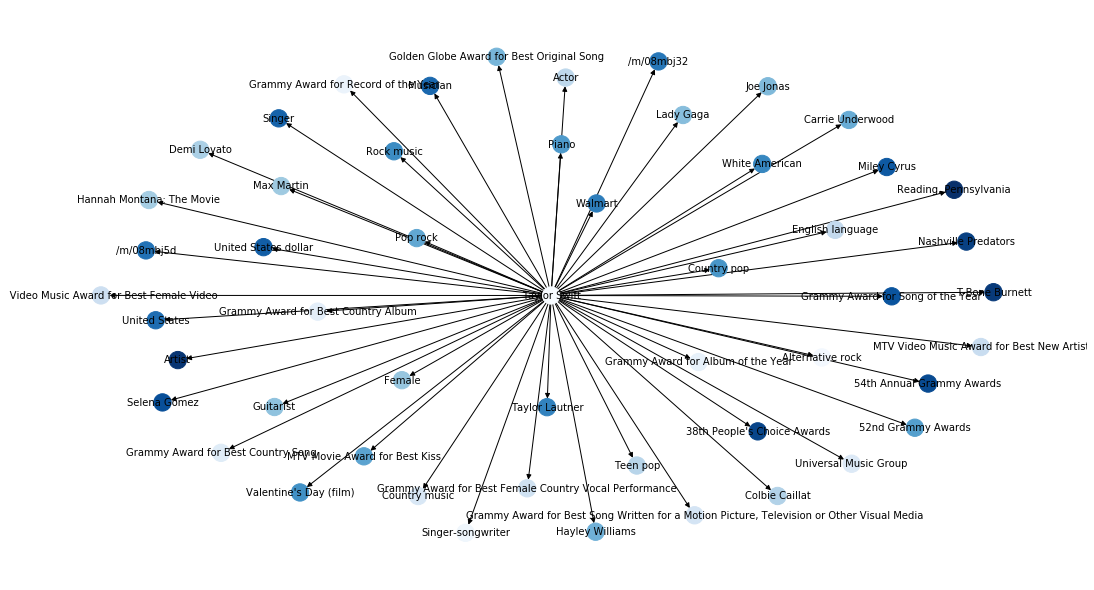

In [8]:
plt.figure(figsize=(15, 8))
# draw the graph
pos=graphviz_layout(graph)
nx.draw(graph, 
        pos=graphviz_layout(graph), 
        labels=labels,
        font_size=10,
        cmap=plt.cm.Blues,
        node_color=range(len(graph)),
        prog='dot')
plt.savefig('FB15k_Graph.png', format='PNG')
plt.show()